In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [3]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [4]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_alig', 'Flux_density', 
             'Width', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Energy', 
             'Polar_l',  'Polar_c', 'RM_syn',  'RM_QUfit', 'Scatt_t', 'Scin_f',]

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if type(value)==str and len(value.strip()) > 0:
        try:
            if '/' in value:
                value = value.split('/')[0]
            if '-' in value and not '+' in value:
                value = value.split('-')[0]
            if value[0] == '+':
                value = value[1:]
                value.split('/')
                value = value[0]
            if value[0] == '<':
                value = value[1:]
            if value[0] == '>':
                value = value[1:]
            return float(value)
        except:
            # print(f"Error: {value}")
            return np.nan
    try:
        return float(value)
    except:
        return np.nan

for col in frb_data[features].columns:
    frb_data[col] = frb_data[col].apply(clean_numeric_value)

In [5]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

train_data, val_data, train_labels, val_labels = train_test_split(
    frb_data_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classification head for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(z)
        return recon_x, mu, logvar, class_prob

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
patience = 4
num_epochs = 150

model = SupervisedVAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
classification_loss_fn = nn.BCELoss() 

def loss_function(recon_x, x, mu, logvar, class_prob, labels):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_loss_fn(class_prob, labels.unsqueeze(1).float())  # Ensure labels match dimensions
    return recon_loss + kl_loss + class_loss, recon_loss, kl_loss, class_loss

Train Epoch: 1 [0/6931 (0%)]	Loss: 27.194761
Train Epoch: 1 [6400/6931 (92%)]	Loss: 11.758763
====> Epoch: 1 Average loss: 20.3120, Recon: 17.2757, KL: 3.0290, Class: 0.0073, Accuracy: 0.8328
====> Validation loss: 12.3096, Recon: 9.2550, KL: 3.0486, Class: 0.0059, Accuracy: 0.8627
New best model saved with validation loss: 12.3096
New best model saved with validation accuracy: 0.8627
Train Epoch: 2 [0/6931 (0%)]	Loss: 43.339996
Train Epoch: 2 [6400/6931 (92%)]	Loss: 12.350799
====> Epoch: 2 Average loss: 16.8316, Recon: 13.1705, KL: 3.6556, Class: 0.0055, Accuracy: 0.8637
====> Validation loss: 11.1814, Recon: 8.3067, KL: 2.8693, Class: 0.0054, Accuracy: 0.8632
New best model saved with validation loss: 11.1814
New best model saved with validation accuracy: 0.8632
Train Epoch: 3 [0/6931 (0%)]	Loss: 10.877938
Train Epoch: 3 [6400/6931 (92%)]	Loss: 11.264731
====> Epoch: 3 Average loss: 15.6316, Recon: 11.9104, KL: 3.7159, Class: 0.0053, Accuracy: 0.8648
====> Validation loss: 10.2603, 

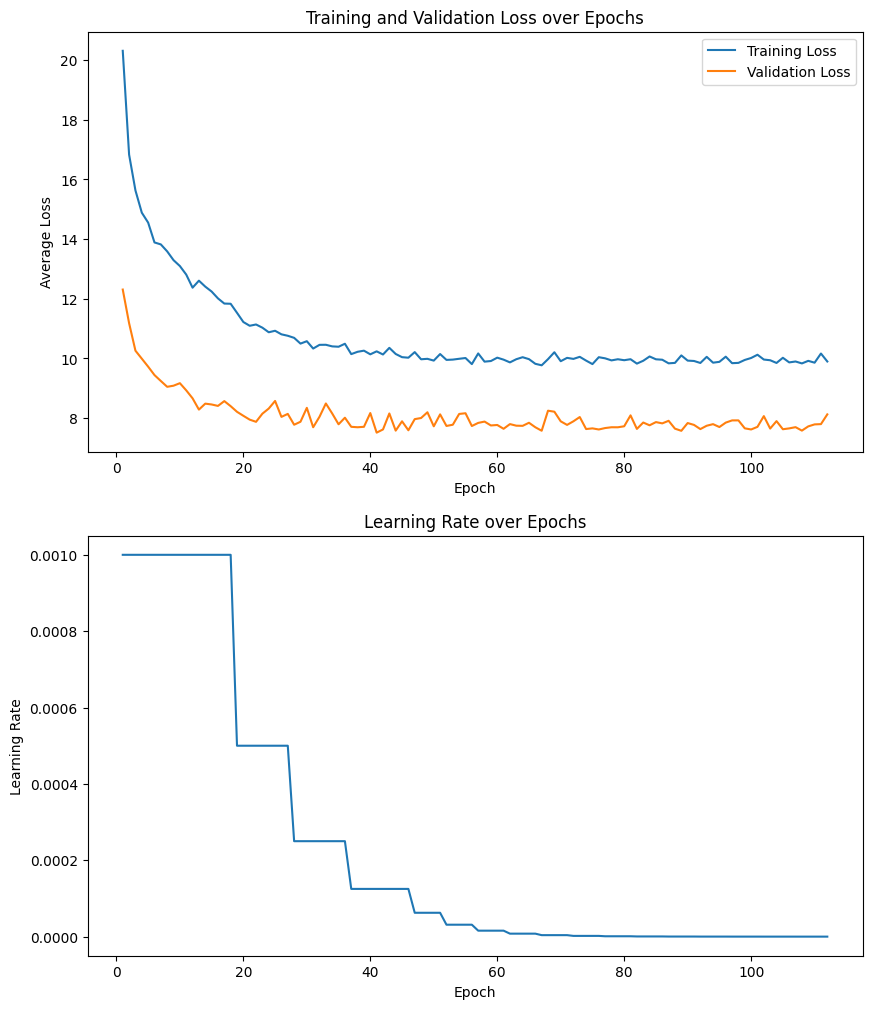

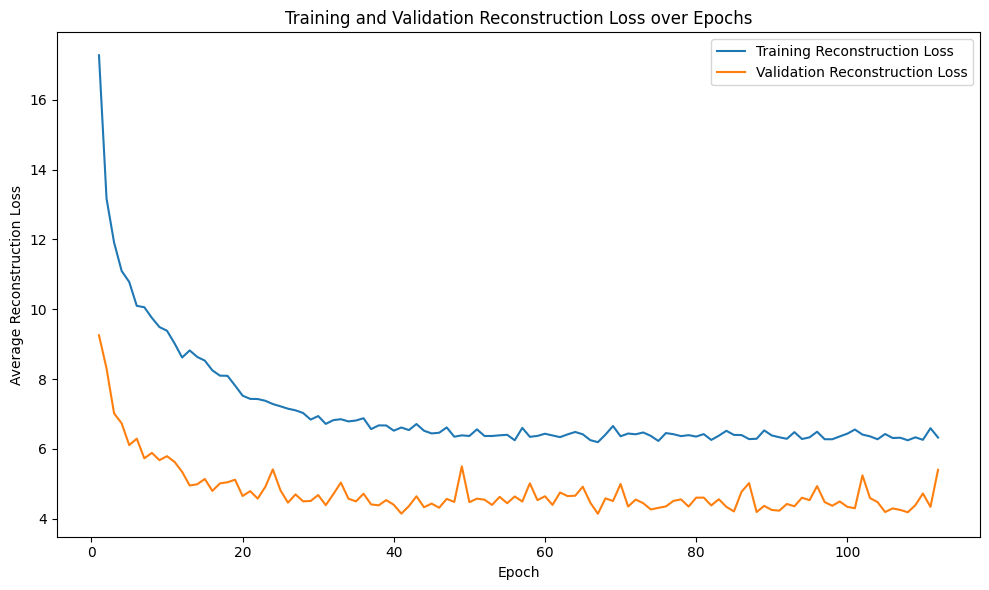

In [9]:
def train_supervised(epoch):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised():
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


best_val_accuracy = 0
best_loss = float('inf')
train_losses, val_losses = [], []
train_recon_losses, val_recon_losses = [], []
train_kl_losses, val_kl_losses = [], []
train_class_losses, val_class_losses = [], []
val_accuracies = []
learning_rates = []

def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss, train_recon, train_kl, train_class, train_accuracy = train_supervised(epoch)
    
    # Validation step
    val_loss, val_recon, val_kl, val_class, val_accuracy = validate_supervised()
    
    # Track losses and accuracy
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recon_losses.append(train_recon)
    val_recon_losses.append(val_recon)
    train_kl_losses.append(train_kl)
    val_kl_losses.append(val_kl)
    train_class_losses.append(train_class)
    val_class_losses.append(val_class)
    val_accuracies.append(val_accuracy)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'supervised_vae_best_loss.pth')
        print(f"New best model saved with validation loss: {best_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'supervised_vae_best_acc.pth')
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    
    # Early stopping
    if early_stopping(val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training complete.")

# Plot training and validation loss, learning rates, and reconstruction loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(learning_rates) + 1), learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(train_recon_losses) + 1), train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(val_recon_losses) + 1), val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()


In [10]:
torch.save(model.state_dict(), 'ssfrb_vae_model.pth')

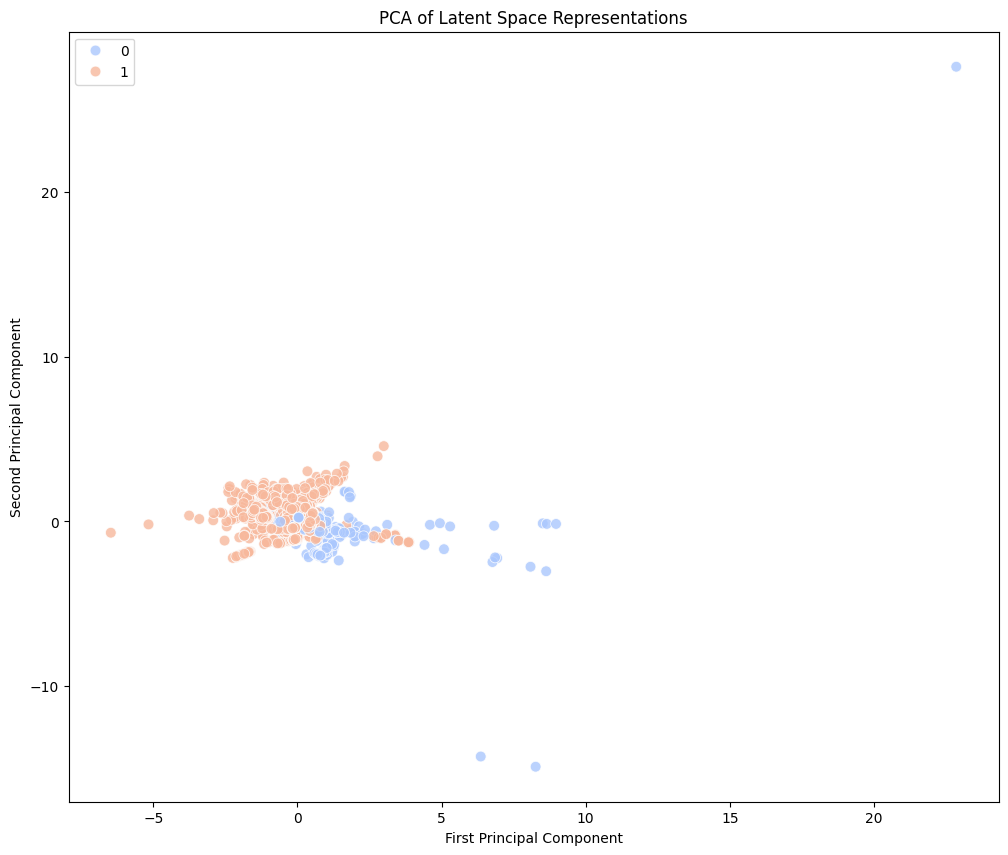

In [11]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

train_latent, train_labels_np = get_latent_representations(model, train_loader, device)
visualize_latent_space_pca(train_latent, train_labels_np, model, device)

In [17]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_latent)
train_clusters = kmeans.labels_

# Evaluate Clustering Performance
sil_score = silhouette_score(train_latent, train_clusters)
ari_score = adjusted_rand_score(train_labels_np, train_clusters)
conf_matrix = confusion_matrix(train_labels_np, train_clusters)

print(f"KMeans Silhouette Score: {sil_score:.4f}")
print(f"KMeans Adjusted Rand Index: {ari_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


KMeans Silhouette Score: 0.2746
KMeans Adjusted Rand Index: -0.0953
Confusion Matrix:
[[ 937   16]
 [4826 1152]]


In [13]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_clusters = gmm.fit_predict(train_latent)
sil_score = silhouette_score(train_latent, gmm_clusters)
ari_score = adjusted_rand_score(train_labels_np, gmm_clusters)
print(f"GMM Silhouette Score: {sil_score:.4f}")
print(f"GMM Adjusted Rand Index: {ari_score:.4f}")

conf_matrix = confusion_matrix(train_labels_np, gmm_clusters)
class_report = classification_report(train_labels_np, gmm_clusters)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

GMM Silhouette Score: 0.4734
GMM Adjusted Rand Index: -0.0145
Confusion Matrix:
[[ 924   29]
 [5719  259]]
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.97      0.24       953
           1       0.90      0.04      0.08      5978

    accuracy                           0.17      6931
   macro avg       0.52      0.51      0.16      6931
weighted avg       0.79      0.17      0.10      6931



Accuracy: 0.9149
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       194
           1       0.94      0.96      0.95      1193

    accuracy                           0.91      1387
   macro avg       0.83      0.80      0.82      1387
weighted avg       0.91      0.91      0.91      1387



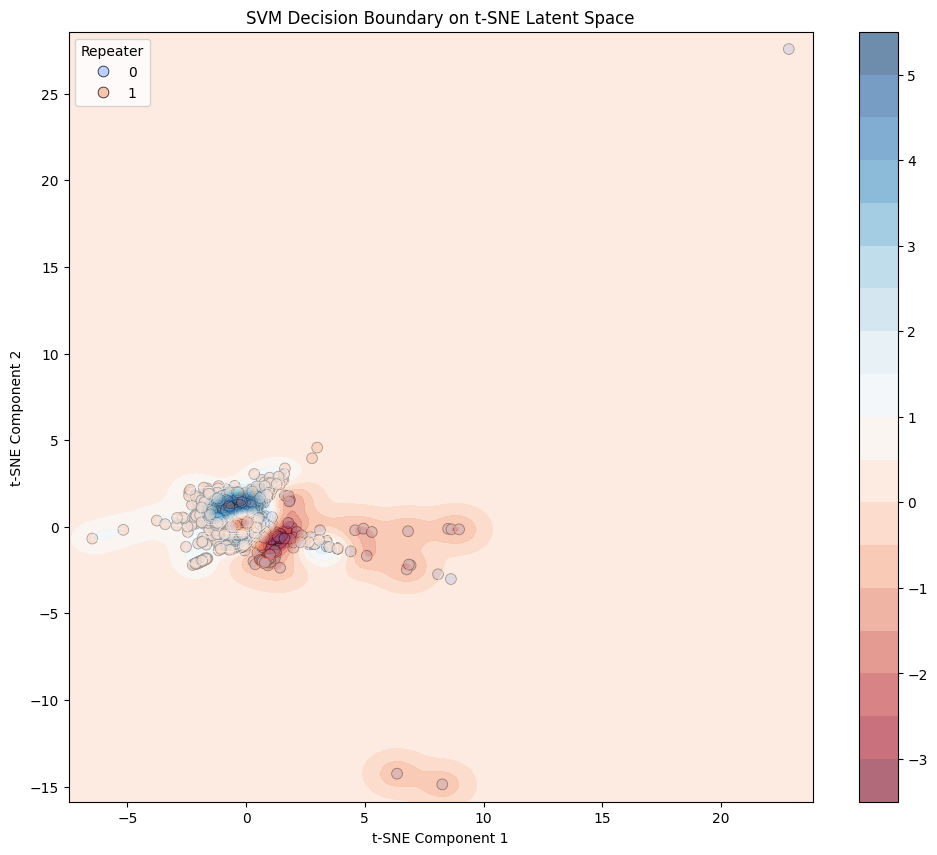

In [14]:
def svm_on_pca(latent_representations, labels, test_size=0.2, random_state=42):
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_representations)
    X_train, X_test, y_train, y_test = train_test_split(latent_pca, labels, test_size=test_size, random_state=random_state)

    svm_model = SVC(kernel='rbf', random_state=random_state)
    svm_model.fit(X_train, y_train)

    # Predict on test set
    y_pred = svm_model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 10))

    sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8, edgecolor='k')

    # Plot decision boundary
    x_min, x_max = latent_pca[:, 0].min() - 1, latent_pca[:, 0].max() + 1
    y_min, y_max = latent_pca[:, 1].min() - 1, latent_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=20, cmap="RdBu", alpha=0.6)  # SVM decision boundary
    
    # Titles and labels
    plt.colorbar()
    plt.title('SVM Decision Boundary on t-SNE Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Repeater')

    plt.show()

svm_on_pca(train_latent, train_labels_np, test_size=0.2, random_state=42)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.9243
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.63      0.70       194
           1       0.94      0.97      0.96      1193

    accuracy                           0.92      1387
   macro avg       0.86      0.80      0.83      1387
weighted avg       0.92      0.92      0.92      1387



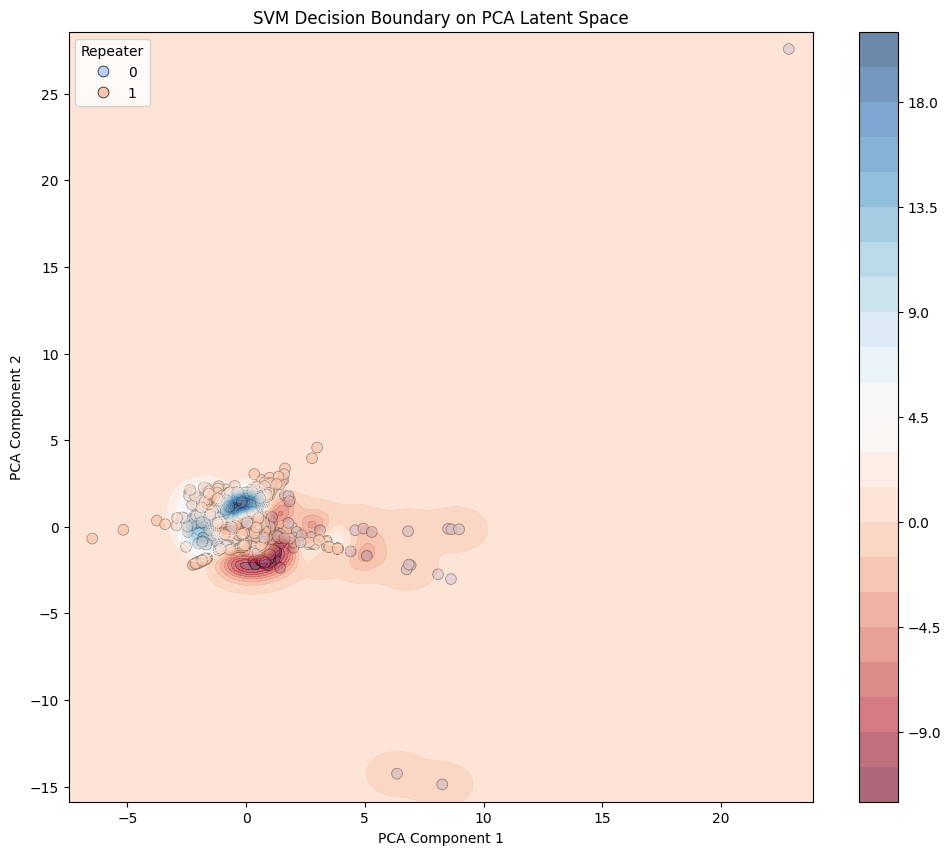

In [15]:
def svm_on_pca_grid(latent_representations, labels, test_size=0.2, random_state=42):
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_representations)
    
    X_train, X_test, y_train, y_test = train_test_split(latent_pca, labels, test_size=test_size, random_state=random_state)
    
    param_grid = {
        'C': [0.1, 1, 10, 100], 
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear'] 
    }

    grid_search = GridSearchCV(SVC(random_state=random_state), param_grid, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    best_svm_model = grid_search.best_estimator_
    y_pred = best_svm_model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8, edgecolor='k')

    x_min, x_max = latent_pca[:, 0].min() - 1, latent_pca[:, 0].max() + 1
    y_min, y_max = latent_pca[:, 1].min() - 1, latent_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    Z = best_svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=20, cmap="RdBu", alpha=0.6)
    
    plt.colorbar()
    plt.title('SVM Decision Boundary on PCA Latent Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Repeater')

    plt.show()

svm_on_pca_grid(train_latent, train_labels_np, test_size=0.2, random_state=42)

In [16]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix


val_accuracy, val_class_report, val_conf_matrix = evaluate_classifier(model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

Validation Accuracy: 0.8898
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.81      0.26      0.39       238
    Repeater       0.89      0.99      0.94      1495

    accuracy                           0.89      1733
   macro avg       0.85      0.62      0.66      1733
weighted avg       0.88      0.89      0.86      1733

Confusion Matrix:
 [[  61  177]
 [  14 1481]]
